# 데이콘 심리성향 예측 대회 정리

(정리를 위한 노트북으로 세부적인 내용은 실제 대회 코드와 차이가 있음)

## 목차

### 1. 대회 소개

### 2. EDA&전처리

2-1. 변수설명  2-2. 결측치 처리  2-3. 데이터 변환
### 3. 변수추가

### 4. 예측모델링

4-1. 모델링 & 평가(교차검증)  4-2. 변수제거 후 모델링&평가

### 5.아쉬운 점& 배울 점

In [3]:
# 기본 세팅
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from IPython.display import Image

#전처리
from sklearn.preprocessing import LabelEncoder, StandardScaler

#데이터분리
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV, train_test_split

#모델링
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgbm

#성과 평가 지표
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix

## 1. 대회소개

1.주제



심리학 테스트 분석 알고리즘 개발
 

2.배경



심리학 테스트의 범주가 넓어짐에 따라 해당 영역의 데이터 분석 방법 탐구
국가 선거 투표자/미투표자의 심리학적 성향을 분석




3.대회 설명



마키아벨리즘 심리테스트를 활용하여 테스트 참가자의 국가 선거 투표 여부 예측 
 

4.주최/주관



주최: DACON
주관: DACON
후원: 이노베이션 아카데미




5.참가 대상



AI 혹은 빅데이터에 관심 있는 누구나
 

6.유저평가



DACON Scholarship을 받고자 하는 팀은 유저평가를 받아야 함

## 2. 데이터 전처리

### 2-1. 변수설명

In [4]:
train=pd.read_csv('train.csv', index_col=0)
test=pd.read_csv('test_x.csv', index_col=0)
submission=pd.read_csv('sample_submission.csv')  

In [6]:
print(train.shape)
print(test.shape)

(45532, 77)
(11383, 76)


In [7]:
train.columns

Index(['QaA', 'QaE', 'QbA', 'QbE', 'QcA', 'QcE', 'QdA', 'QdE', 'QeA', 'QeE',
       'QfA', 'QfE', 'QgA', 'QgE', 'QhA', 'QhE', 'QiA', 'QiE', 'QjA', 'QjE',
       'QkA', 'QkE', 'QlA', 'QlE', 'QmA', 'QmE', 'QnA', 'QnE', 'QoA', 'QoE',
       'QpA', 'QpE', 'QqA', 'QqE', 'QrA', 'QrE', 'QsA', 'QsE', 'QtA', 'QtE',
       'age_group', 'education', 'engnat', 'familysize', 'gender', 'hand',
       'married', 'race', 'religion', 'tp01', 'tp02', 'tp03', 'tp04', 'tp05',
       'tp06', 'tp07', 'tp08', 'tp09', 'tp10', 'urban', 'voted', 'wf_01',
       'wf_02', 'wf_03', 'wr_01', 'wr_02', 'wr_03', 'wr_04', 'wr_05', 'wr_06',
       'wr_07', 'wr_08', 'wr_09', 'wr_10', 'wr_11', 'wr_12', 'wr_13'],
      dtype='object')

index

 Q_A 마키아벨리 심리 테스트의 문항별 응답
 
 Q_E 마키아벨리 심리 테스트 응답시 소비 시간
* Qa : Secret
* Qb : The biggest difference between most criminals and other people is that the criminals are stupid enough to get caught.
* Qc : Anyone who completely trusts anyone else is asking for trouble.
* Qd : Secret
* Qe : P.T. Barnum was wrong when he said that there's a sucker born every minute.
* Qf : There is no excuse for lying to someone else.
* Qg : Secret
* Qh : Most people forget more easily the death of their parents than the loss of their property.
* Qi : Secret
* Qj : It is safest to assume that all people have a vicious streak and it will come out when they are given a chance.
* Qk : All in all, it is better to be humble and honest than to be important and dishonest.
* Ql : Secret
* Qm : It is hard to get ahead without cutting corners here and there.
* Qn : Secret
* Qo : The best way to handle people is to tell them what they want to hear.
* Qp : Secret
* Qq : Most people are basically good and kind.
* Qr : One should take action only when sure it is morally right.
* Qs : It is wise to flatter important people.
* Qt : Secret

(1=Disagree, 2=Slightly disagree, 3=Neutral, 4=Slightly agree, 5=Agree.)






age_group : 연령


education : 교육 수준
- 1=Less than high school, 2=High school, 3=University degree, 4=Graduate degree, 0=무응답


engnat : 모국어가 영어
- 1=Yes, 2=No, 0=무응답


familysize : 형제자매 수


gender : 성별
- Male, Female


hand : 필기하는 손
- 1=Right, 2=Left, 3=Both, 0=무응답


married : 혼인 상태
- 1=Never married, 2=Currently married, 3=Previously married, 0=Other


race : 인종
- Asian, Arab, Black, Indigenous Australian, Native American, White, Other


religion : 종교
- Agnostic, Atheist, Buddhist, Christian_Catholic, Christian_Mormon, Christian_Protestant, Christian_Other, Hindu, Jewish, Muslim, Sikh, Other


tp__(01~07) : items were rated "I see myself as:" _____ such that
tp01 : Extraverted, enthusiastic.
tp02 : Critical, quarrelsome.
tp03 : Dependable, self-disciplined.
tp04 : Anxious, easily upset.
tp05 : Open to new experiences, complex.
tp06 : Reserved, quiet.
tp07 : Sympathetic, warm.
tp08 : Disorganized, careless.
tp09 : Calm, emotionally stable.
tp10 : Conventional, uncreative.
								

순서형 변수

							



urban : 유년기의 거주 구역
- 1=Rural (country side), 2=Suburban, 3=Urban (town, city), 0=무응답




wr_(01~13) : 실존하는 해당 단어의 정의을 앎
- 1=Yes, 0=No
wf_(01~03) : 허구인 단어의 정의를 앎
- 1=Yes, 0=No


voted (타겟): 지난 해 국가 선거 투표 여부
1=Yes, 2=No


## 2-2. 결측치 처리

데이터 확인 결과 'education','engnat','hand', 'married', 'urban', 'Q_E','race','tp' 변수에서  결측치가 나타나며, 

familysize에서는 999, 100 등의 이상치가 나타난다.

이상치나 결측치의 수가 거의 없는 'Q_E'와 'familysize'변수는 이상치& 결측치를 제거해준 뒤 나머지 변수들은 변수관계를 활용하여 결측치를 처리한다.

#### 또한 따로 점수환산하는 방식이 있는 TIPI 변수는 점수환산 방식을 고려하여 나중에 따로 결측치를 처리한다

(data를 확인하는 코드는 용량이 너무 크기에 주석처리를 해둔다.)

In [363]:
#데이터 확인 코드

#print(train['education'].value_counts(),test['education'].value_counts())
#print(train['engnat'].value_counts(),test['engnat'].value_counts())
#print(train['hand'].value_counts(),test['hand'].value_counts())
#print(train['married'].value_counts(),test['married'].value_counts())
#print(train['urban'].value_counts(),test['urban'].value_counts())
#print(train['familysize'].value_counts(),test['familysize'].value_counts())

### familysize 이상치 처리
test에는 이상치나 결측치가 없고 train에만 존재하기에 이상치를 가진행을 삭제한다

In [364]:
train=train[train['familysize']<100]

### Q_E 변수들 결측치 처리
마키아벨리 설문에서 각 문항별 걸린 시간을 나타냄으로 0을 결측치로 처리한다.

train에서는 결측치를 가진 행을 제거하고, test는 중위값으로 전환해준다.

In [365]:
train=train[(train['QaE']>0)&(train['QbE']>0)&(train['QcE']>0)&(train['QdE']>0)&(train['QeE']>0)&(train['QfE']>0)&(train['QgE']>0)&(train['QhE']>0)&(train['QiE']>0)&(train['QjE']>0)&(train['QkE']>0)&(train['QlE']>0)&(train['QmE']>0)&(train['QnE']>0)&(train['QoE']>0)&(train['QpE']>0)&(train['QqE']>0)&(train['QrE']>0)&(train['QsE']>0)&(train['QtE']>0)]

#test에서 시간==0 이면 중위값으로 변경
test['QaE']=test['QaE'].replace(0,np.median(test['QaE']),)
test['QbE']=test['QbE'].replace(0,np.median(test['QbE']))
test['QcE']=test['QcE'].replace(0,np.median(test['QcE']))
test['QdE']=test['QdE'].replace(0,np.median(test['QdE']))
test['QeE']=test['QeE'].replace(0,np.median(test['QeE']))
test['QfE']=test['QfE'].replace(0,np.median(test['QfE']))
test['QgE']=test['QgE'].replace(0,np.median(test['QgE']))
test['QhE']=test['QhE'].replace(0,np.median(test['QhE']))
test['QiE']=test['QiE'].replace(0,np.median(test['QiE']))
test['QjE']=test['QjE'].replace(0,np.median(test['QjE']))
test['QkE']=test['QkE'].replace(0,np.median(test['QkE']))
test['QlE']=test['QlE'].replace(0,np.median(test['QlE']))
test['QmE']=test['QmE'].replace(0,np.median(test['QmE']))
test['QnE']=test['QnE'].replace(0,np.median(test['QnE']))
test['QoE']=test['QoE'].replace(0,np.median(test['QoE']))
test['QpE']=test['QpE'].replace(0,np.median(test['QpE']))
test['QqE']=test['QqE'].replace(0,np.median(test['QqE']))
test['QrE']=test['QrE'].replace(0,np.median(test['QrE']))
test['QsE']=test['QsE'].replace(0,np.median(test['QsE']))
test['QtE']=test['QtE'].replace(0,np.median(test['QtE']))


### 다른변수들의 결측치는 변수들간의 상관관계를 고려하여 처리한다.

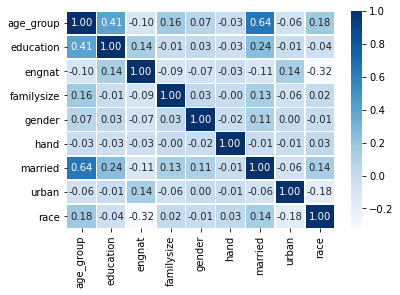

In [366]:
data=train.copy()
test=test.copy()


a=data.loc[:,['age_group', 'education', 'engnat', 'familysize', 'gender', 'hand', 'married', 'religion','urban','race']]
a['age_group'].replace(['10s','20s','30s','40s','50s','60s','+70s'],[1,2,3,4,5,6,7],inplace=True)
a['gender'].replace(['Male','Female'],[1,2],inplace=True)
a['race'].replace(['White','Asian','Other','Black','Native American','Arab','Indigenous Australian'],[7,2,6,3,5,1,4],inplace=True)


sns.heatmap(data=a.corr(),annot=True,fmt='.2f', linewidths=.5,cmap='Blues')
fig=plt.gcf() # fig에 접근
plt.show()


### hand 변수 결측치 처리

다른 변수들과 상관성이 거의 없기에, 최빈값 1으로 결측치를 처리한다.

In [367]:
print(data['hand'].value_counts())
print(test['hand'].value_counts())

1    39050
2     4691
3     1620
0      161
Name: hand, dtype: int64
1    9818
2    1155
3     370
0      40
Name: hand, dtype: int64


In [368]:
data[(data['hand'] == 0)] = data[(data['hand'] == 0)].replace({'hand': 0}, {'hand': 1})
test[(test['hand'] == 0)] = test[(test['hand'] == 0)].replace({'hand': 0}, {'hand': 1})

### married 변수 결측치 처리

age_group변수와 상관성이 높게 나타나는 것을 알 수 있으므로 age_group변수를 고려한 최빈값으로 결측치를 처리한다.

In [369]:
pd.crosstab(a.age_group,data.married,margins=True).style.background_gradient(cmap='summer_r')

married,0,1,2,3,All
age_group,,,,,
1,40,14069,73,27,14209
2,19,12314,1495,281,14109
3,10,3539,3296,991,7836
4,16,1086,2762,1187,5051
5,4,407,1575,903,2889
6,4,112,722,356,1194
7,0,14,136,84,234
All,93,31541,10059,3829,45522


In [370]:
data[(data['married'] == 0) & (data['age_group'] == '10s')] = data[(data['married'] == 0) & (data['age_group'] == '10s')].replace({'married': 0}, {'married': 1})
data[(data['married'] == 0) & (data['age_group'] == '20s')] = data[(data['married'] == 0) & (data['age_group'] == '20s')].replace({'married': 0}, {'married': 1})
data[(data['married'] == 0) & (data['age_group'] == '30s')] = data[(data['married'] == 0) & (data['age_group'] == '20s')].replace({'married': 0}, {'married': 1})
data[(data['married'] == 0) & (data['age_group'] == '40s')] = data[(data['married'] == 0) & (data['age_group'] == '40s')].replace({'married': 0}, {'married': 2})
data[(data['married'] == 0) & (data['age_group'] == '50s')] = data[(data['married'] == 0) & (data['age_group'] == '50s')].replace({'married': 0}, {'married': 2})
data[(data['married'] == 0) & (data['age_group'] == '60s')] = data[(data['married'] == 0) & (data['age_group'] == '60s')].replace({'married': 0}, {'married': 2})
data[(data['married'] == 0) & (data['age_group'] == '+70s')] = data[(data['married'] == 0) & (data['age_group'] == '70s')].replace({'married': 0}, {'married': 2})

In [371]:
test[(test['married'] == 0) & (test['age_group'] == '10s')] = test[(test['married'] == 0) & (test['age_group'] == '10s')].replace({'married': 0}, {'married': 1})
test[(test['married'] == 0) & (test['age_group'] == '20s')] = test[(test['married'] == 0) & (test['age_group'] == '20s')].replace({'married': 0}, {'married': 1})
test[(test['married'] == 0) & (test['age_group'] == '30s')] = test[(test['married'] == 0) & (test['age_group'] == '20s')].replace({'married': 0}, {'married': 1})
test[(test['married'] == 0) & (test['age_group'] == '40s')] = test[(test['married'] == 0) & (test['age_group'] == '40s')].replace({'married': 0}, {'married': 2})
test[(test['married'] == 0) & (test['age_group'] == '50s')] = test[(test['married'] == 0) & (test['age_group'] == '50s')].replace({'married': 0}, {'married': 2})
test[(test['married'] == 0) & (test['age_group'] == '60s')] = test[(test['married'] == 0) & (test['age_group'] == '60s')].replace({'married': 0}, {'married': 2})
test[(test['married'] == 0) & (test['age_group'] == '+70s')] = test[(test['married'] == 0) & (test['age_group'] == '+70s')].replace({'married': 0}, {'married': 2})

In [372]:
print(data['married'].value_counts())
print(test['married'].value_counts())

1.0    31600
2.0    10083
3.0     3829
Name: married, dtype: int64
1.0    7944
2.0    2475
3.0     958
Name: married, dtype: int64


### education변수 결측치 처리

education변수가 age_graoup변수와 높은 상관관계를 보이기에 age_graoup변수를 고려한 최빈값으로 결측치를 처리한다.

In [373]:
pd.crosstab(data.age_group,data.education,margins=True).style.background_gradient(cmap='summer_r')

education,0.0,1.0,2.0,3.0,4.0,All
age_group,,,,,,
+70s,5,9,69,64,87,234
10s,115,4571,8235,1114,174,14209
20s,134,207,4164,6990,2614,14109
30s,111,157,1921,3398,2239,7826
40s,78,80,1282,2116,1495,5051
50s,59,48,804,1134,844,2889
60s,26,14,350,406,398,1194
All,528,5086,16825,15222,7851,45512


In [374]:
data[(data['age_group'] == '10s') & (data['education'] == 0)] = data[(data['age_group'] == '10s') & (data['education'] == 0)].replace({'education': 0}, {'education': 2})
data[(data['age_group'] == '20s') & (data['education'] == 0)] = data[(data['age_group'] == '20s') & (data['education'] == 0)].replace({'education': 0}, {'education': 3})
data[(data['age_group'] == '30s') & (data['education'] == 0)] = data[(data['age_group'] == '30s') & (data['education'] == 0)].replace({'education': 0}, {'education': 3})
data[(data['age_group'] == '40s') & (data['education'] == 0)] = data[(data['age_group'] == '40s') & (data['education'] == 0)].replace({'education': 0}, {'education': 3})
data[(data['age_group'] == '50s') & (data['education'] == 0)] = data[(data['age_group'] == '50s') & (data['education'] == 0)].replace({'education': 0}, {'education': 3})
data[(data['age_group'] == '60s') & (data['education'] == 0)] = data[(data['age_group'] == '60s') & (data['education'] == 0)].replace({'education': 0}, {'education': 3})
data[(data['age_group'] == '+70s') & (data['education'] == 0)] = data[(data['age_group'] == '+70s') & (data['education'] == 0)].replace({'education': 0}, {'education': 4})

In [375]:
data[(data['age_group'] == '10s') & (data['education'] == 0)] = data[(data['age_group'] == '10s') & (data['education'] == 0)].replace({'education': 0}, {'education': 2})
data[(data['age_group'] == '20s') & (data['education'] == 0)] = data[(data['age_group'] == '20s') & (data['education'] == 0)].replace({'education': 0}, {'education': 3})
data[(data['age_group'] == '30s') & (data['education'] == 0)] = data[(data['age_group'] == '30s') & (data['education'] == 0)].replace({'education': 0}, {'education': 3})
data[(data['age_group'] == '40s') & (data['education'] == 0)] = data[(data['age_group'] == '40s') & (data['education'] == 0)].replace({'education': 0}, {'education': 3})
data[(data['age_group'] == '50s') & (data['education'] == 0)] = data[(data['age_group'] == '50s') & (data['education'] == 0)].replace({'education': 0}, {'education': 3})
data[(data['age_group'] == '60s') & (data['education'] == 0)] = data[(data['age_group'] == '60s') & (data['education'] == 0)].replace({'education': 0}, {'education': 3})
data[(data['age_group'] == '+70s') & (data['education'] == 0)] = data[(data['age_group'] == '+70s') & (data['education'] == 0)].replace({'education': 0}, {'education': 4})

### engnat변수 결측치 처리
egnant(모국어가 영어인지)가 race변수와 상관관계가 높음을 알 수 있다. 그래프 확인 후 인종변수를 고려한 최빈값으로 결측치를 처리한다.

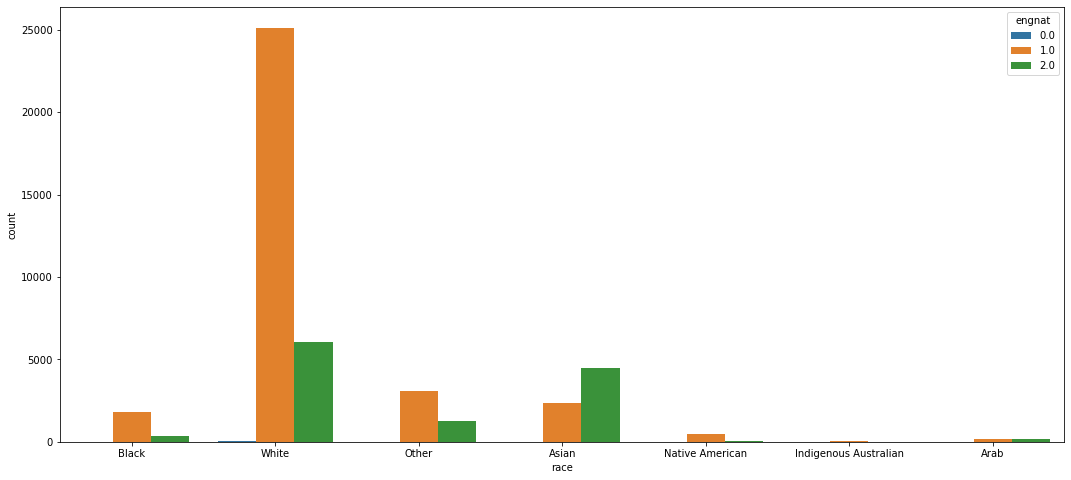

In [376]:
plt.subplots(figsize=(18,8))
sns.countplot('race',hue='engnat',data=data)
plt.show()

In [377]:
pd.crosstab(data.race,data.engnat,margins=True).style.background_gradient(cmap='summer_r')

engnat,0.0,1.0,2.0,All
race,,,,
Arab,1,152,196,349
Asian,13,2334,4485,6832
Black,4,1812,349,2165
Indigenous Australian,0,47,6,53
Native American,0,488,60,548
Other,8,3055,1263,4326
White,51,25123,6065,31239
All,77,33011,12424,45512


In [378]:
data[(data['engnat'] == 0) & (data['race'] == 'White')] = data[(data['engnat'] == 0) & (data['race'] == 'White')].replace({'engnat': 0}, {'engnat': 1})
data[(data['engnat'] == 0) & (data['race'] == 'Black')] = data[(data['engnat'] == 0) & (data['race'] == 'Black')].replace({'engnat': 0}, {'engnat': 1})
data[(data['engnat'] == 0) & (data['race'] == 'Other')] = data[(data['engnat'] == 0) & (data['race'] == 'Other')].replace({'engnat': 0}, {'engnat': 1})
data[(data['engnat'] == 0) & (data['race'] == 'Asian')] = data[(data['engnat'] == 0) & (data['race'] == 'Asian')].replace({'engnat': 0}, {'engnat': 2})
data[(data['engnat'] == 0) & (data['race'] == 'Arab')] = data[(data['engnat'] == 0) & (data['race'] == 'Arab')].replace({'engnat': 0}, {'engnat': 2})

In [379]:
test[(test['engnat'] == 0) & (test['race'] == 'White')] = test[(test['engnat'] == 0) & (test['race'] == 'White')].replace({'engnat': 0}, {'engnat': 1})
test[(test['engnat'] == 0) & (test['race'] == 'Black')] = test[(test['engnat'] == 0) & (test['race'] == 'Black')].replace({'engnat': 0}, {'engnat': 1})
test[(test['engnat'] == 0) & (test['race'] == 'Other')] = test[(test['engnat'] == 0) & (test['race'] == 'Other')].replace({'engnat': 0}, {'engnat': 1})
test[(test['engnat'] == 0) & (test['race'] == 'Asian')] = test[(test['engnat'] == 0) & (test['race'] == 'Asian')].replace({'engnat': 0}, {'engnat': 2})
test[(test['engnat'] == 0) & (test['race'] == 'Arab')] = test[(test['engnat'] == 0) & (test['race'] == 'Arab')].replace({'engnat': 0}, {'engnat': 2})


### urban변수 결측치 처리
urban변수가 race변수와 상관관계가 높음을 알 수 있다. 그래프 확인 후 인종변수를 고려한 최빈값으로 결측치를 처리한다.

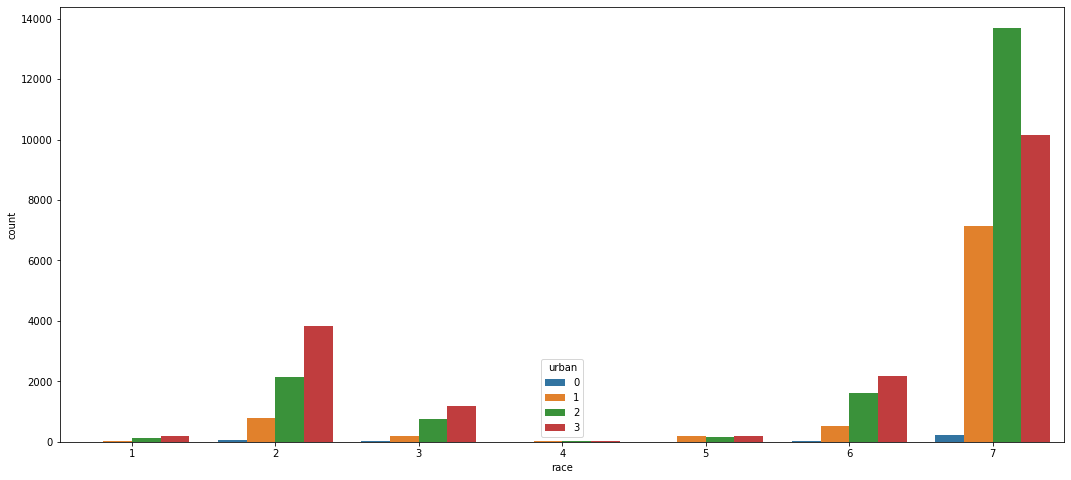

In [380]:
#race와 urban의 그래프
plt.subplots(figsize=(18,8))
sns.countplot('race',hue='urban',data=a)
plt.show()

In [381]:
pd.crosstab(a.race,data.urban,margins=True).style.background_gradient(cmap='summer_r')

urban,0.0,1.0,2.0,3.0,All
race,,,,,
1,0,31,118,200,349
2,48,803,2145,3836,6832
3,21,205,764,1175,2165
4,0,19,24,10,53
5,3,183,167,195,548
6,31,511,1610,2174,4326
7,219,7153,13702,10165,31239
All,322,8905,18530,17755,45512


In [382]:
data[(data['urban'] == 0) & (data['race'] == 'Arab')] = data[(data['urban'] == 0) & (data['race'] == 'Arab')].replace({'urban': 0}, {'urban': 3})
data[(data['urban'] == 0) & (data['race'] == 'Asian')] = data[(data['urban'] == 0) & (data['race'] == 'Asian')].replace({'urban': 0}, {'urban': 3})
data[(data['urban'] == 0) & (data['race'] == 'Black')] = data[(data['urban'] == 0) & (data['race'] == 'Black')].replace({'urban': 0}, {'urban': 3})
data[(data['urban'] == 0) & (data['race'] == 'Indigenous Australian')] = data[(data['urban'] == 0) & (data['race'] == 'Indigenous Australian')].replace({'urban': 0}, {'urban': 2})
data[(data['urban'] == 0) & (data['race'] == 'Native American')] = data[(data['urban'] == 0) & (data['race'] == 'Native American')].replace({'urban': 0}, {'urban': 3})
data[(data['urban'] == 0) & (data['race'] == 'Other')] = data[(data['urban'] == 0) & (data['race'] == 'Other')].replace({'urban': 0}, {'urban': 3})
data[(data['urban'] == 0) & (data['race'] == 'White')] = data[(data['urban'] == 0) & (data['race'] == 'White')].replace({'urban': 0}, {'urban': 2})

In [383]:
test[(test['urban'] == 0) & (test['race'] == 'Arab')] = test[(test['urban'] == 0) & (test['race'] == 'Arab')].replace({'urban': 0}, {'urban': 3})
test[(test['urban'] == 0) & (test['race'] == 'Asian')] = test[(test['urban'] == 0) & (test['race'] == 'Asian')].replace({'urban': 0}, {'urban': 3})
test[(test['urban'] == 0) & (test['race'] == 'Black')] = test[(test['urban'] == 0) & (test['race'] == 'Black')].replace({'urban': 0}, {'urban': 3})
test[(test['urban'] == 0) & (test['race'] == 'Indigenous Australian')] = test[(test['urban'] == 0) & (test['race'] == 'Indigenous Australian')].replace({'urban': 0}, {'urban': 2})
test[(test['urban'] == 0) & (test['race'] == 'Native American')] = test[(test['urban'] == 0) & (test['race'] == 'Native American')].replace({'urban': 0}, {'urban': 3})
test[(test['urban'] == 0) & (test['race'] == 'Other')] = test[(test['urban'] == 0) & (test['race'] == 'Other')].replace({'urban': 0}, {'urban': 3})
test[(test['urban'] == 0) & (test['race'] == 'White')] = test[(test['urban'] == 0) & (test['race'] == 'White')].replace({'urban': 0}, {'urban': 2})

### TIPI변수들 결측치 처리

TIPI 변수들은 도메인 지식을 활용하여, 결측치를 처리한다. 

TIPI 변수들은 심리 테스트에 대한 답변으로 짝이 되는 문항들이 존재한다. 그렇기에 짝이 되는 문항들을 최대한 고려하여 결측치를 처리한 뒤 그 후에 남은 결측치들은 중앙값으로 결측치를 처리하기로한다.

#### 우선, 현재 tipi점수들은 역수로 입력되어 있으므로 원래 값으로 변환해준 뒤 결측치를 처리한다.

In [384]:
#역수 변환
data['tp01'] = 7 - data['tp01']
data['tp02'] = 7 - data['tp02']
data['tp03'] = 7 - data['tp03']
data['tp04'] = 7 - data['tp04']
data['tp05'] = 7 - data['tp05']
data['tp06'] = 7 - data['tp06']
data['tp07'] = 7 - data['tp07']
data['tp08'] = 7 - data['tp08']
data['tp09'] = 7 - data['tp09']
data['tp10'] = 7 - data['tp10']

In [385]:
test['tp01'] = 7 - test['tp01']
test['tp02'] = 7 - test['tp02']
test['tp03'] = 7 - test['tp03']
test['tp04'] = 7 - test['tp04']
test['tp05'] = 7 - test['tp05']
test['tp06'] = 7 - test['tp06']
test['tp06'] = 7 - test['tp06']
test['tp07'] = 7 - test['tp07']
test['tp08'] = 7 - test['tp08']
test['tp09'] = 7 - test['tp09']
test['tp10'] = 7 - test['tp10']

<AxesSubplot:xlabel='tp01', ylabel='count'>

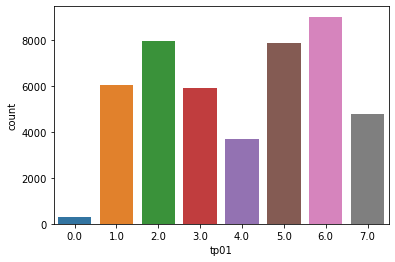

In [386]:
sns.countplot('tp01',data=data)

#### 짝이 되는 변수들을 고려하여 0으로 입력된 결측치를 처리

In [387]:
data_tr=train
data_te=test

data_tr[(data_tr['tp01'] == 0) & (data_tr['tp06'] == 1)] = data_tr[(data_tr['tp01'] == 0) & (data_tr['tp06'] == 1)].replace({'tp01':0},{'tp01':1})
data_tr[(data_tr['tp01'] == 0) & (data_tr['tp06'] == 2)] = data_tr[(data_tr['tp01'] == 0) & (data_tr['tp06'] == 2)].replace({'tp01':0},{'tp01':2})
data_tr[(data_tr['tp01'] == 0) & (data_tr['tp06'] == 3)] = data_tr[(data_tr['tp01'] == 0) & (data_tr['tp06'] == 3)].replace({'tp01':0},{'tp01':3})
data_tr[(data_tr['tp01'] == 0) & (data_tr['tp06'] == 4)] = data_tr[(data_tr['tp01'] == 0) & (data_tr['tp06'] == 4)].replace({'tp01':0},{'tp01':4})
data_tr[(data_tr['tp01'] == 0) & (data_tr['tp06'] == 5)] = data_tr[(data_tr['tp01'] == 0) & (data_tr['tp06'] == 5)].replace({'tp01':0},{'tp01':5})
data_tr[(data_tr['tp01'] == 0) & (data_tr['tp06'] == 6)] = data_tr[(data_tr['tp01'] == 0) & (data_tr['tp06'] == 6)].replace({'tp01':0},{'tp01':6})
data_tr[(data_tr['tp01'] == 0) & (data_tr['tp06'] == 7)] = data_tr[(data_tr['tp01'] == 0) & (data_tr['tp06'] == 7)].replace({'tp01':0},{'tp01':7})

data_tr[(data_tr['tp02'] == 0) & (data_tr['tp07'] == 1)] = data_tr[(data_tr['tp02'] == 0) & (data_tr['tp07'] == 1)].replace({'tp02':0},{'tp02':1})
data_tr[(data_tr['tp02'] == 0) & (data_tr['tp07'] == 2)] = data_tr[(data_tr['tp02'] == 0) & (data_tr['tp07'] == 2)].replace({'tp02':0},{'tp02':2})
data_tr[(data_tr['tp02'] == 0) & (data_tr['tp07'] == 3)] = data_tr[(data_tr['tp02'] == 0) & (data_tr['tp07'] == 3)].replace({'tp02':0},{'tp02':3})
data_tr[(data_tr['tp02'] == 0) & (data_tr['tp07'] == 4)] = data_tr[(data_tr['tp02'] == 0) & (data_tr['tp07'] == 4)].replace({'tp02':0},{'tp02':4})
data_tr[(data_tr['tp02'] == 0) & (data_tr['tp07'] == 5)] = data_tr[(data_tr['tp02'] == 0) & (data_tr['tp07'] == 5)].replace({'tp02':0},{'tp02':5})
data_tr[(data_tr['tp02'] == 0) & (data_tr['tp07'] == 6)] = data_tr[(data_tr['tp02'] == 0) & (data_tr['tp07'] == 6)].replace({'tp02':0},{'tp02':6})
data_tr[(data_tr['tp02'] == 0) & (data_tr['tp07'] == 7)] = data_tr[(data_tr['tp02'] == 0) & (data_tr['tp07'] == 7)].replace({'tp02':0},{'tp02':7})

data_tr[(data_tr['tp03'] == 0) & (data_tr['tp08'] == 1)] = data_tr[(data_tr['tp03'] == 0) & (data_tr['tp08'] == 1)].replace({'tp03':0},{'tp03':1})
data_tr[(data_tr['tp03'] == 0) & (data_tr['tp08'] == 2)] = data_tr[(data_tr['tp03'] == 0) & (data_tr['tp08'] == 2)].replace({'tp03':0},{'tp03':2})
data_tr[(data_tr['tp03'] == 0) & (data_tr['tp08'] == 3)] = data_tr[(data_tr['tp03'] == 0) & (data_tr['tp08'] == 3)].replace({'tp03':0},{'tp03':3})
data_tr[(data_tr['tp03'] == 0) & (data_tr['tp08'] == 4)] = data_tr[(data_tr['tp03'] == 0) & (data_tr['tp08'] == 4)].replace({'tp03':0},{'tp03':4})
data_tr[(data_tr['tp03'] == 0) & (data_tr['tp08'] == 5)] = data_tr[(data_tr['tp03'] == 0) & (data_tr['tp08'] == 5)].replace({'tp03':0},{'tp03':5})
data_tr[(data_tr['tp03'] == 0) & (data_tr['tp08'] == 6)] = data_tr[(data_tr['tp03'] == 0) & (data_tr['tp08'] == 6)].replace({'tp03':0},{'tp03':6})
data_tr[(data_tr['tp03'] == 0) & (data_tr['tp08'] == 7)] = data_tr[(data_tr['tp03'] == 0) & (data_tr['tp08'] == 7)].replace({'tp03':0},{'tp03':7})

data_tr[(data_tr['tp04'] == 0) & (data_tr['tp09'] == 1)] = data_tr[(data_tr['tp04'] == 0) & (data_tr['tp09'] == 1)].replace({'tp04':0},{'tp04':1})
data_tr[(data_tr['tp04'] == 0) & (data_tr['tp09'] == 2)] = data_tr[(data_tr['tp04'] == 0) & (data_tr['tp09'] == 2)].replace({'tp04':0},{'tp04':2})
data_tr[(data_tr['tp04'] == 0) & (data_tr['tp09'] == 3)] = data_tr[(data_tr['tp04'] == 0) & (data_tr['tp09'] == 3)].replace({'tp04':0},{'tp04':3})
data_tr[(data_tr['tp04'] == 0) & (data_tr['tp09'] == 4)] = data_tr[(data_tr['tp04'] == 0) & (data_tr['tp09'] == 4)].replace({'tp04':0},{'tp04':4})
data_tr[(data_tr['tp04'] == 0) & (data_tr['tp09'] == 5)] = data_tr[(data_tr['tp04'] == 0) & (data_tr['tp09'] == 5)].replace({'tp04':0},{'tp04':5})
data_tr[(data_tr['tp04'] == 0) & (data_tr['tp09'] == 6)] = data_tr[(data_tr['tp04'] == 0) & (data_tr['tp09'] == 6)].replace({'tp04':0},{'tp04':6})
data_tr[(data_tr['tp04'] == 0) & (data_tr['tp09'] == 7)] = data_tr[(data_tr['tp04'] == 0) & (data_tr['tp09'] == 7)].replace({'tp04':0},{'tp04':7})

data_tr[(data_tr['tp05'] == 0) & (data_tr['tp10'] == 1)] = data_tr[(data_tr['tp05'] == 0) & (data_tr['tp10'] == 1)].replace({'tp05':0},{'tp05':1})
data_tr[(data_tr['tp05'] == 0) & (data_tr['tp10'] == 2)] = data_tr[(data_tr['tp05'] == 0) & (data_tr['tp10'] == 2)].replace({'tp05':0},{'tp05':2})
data_tr[(data_tr['tp05'] == 0) & (data_tr['tp10'] == 3)] = data_tr[(data_tr['tp05'] == 0) & (data_tr['tp10'] == 3)].replace({'tp05':0},{'tp05':3})
data_tr[(data_tr['tp05'] == 0) & (data_tr['tp10'] == 4)] = data_tr[(data_tr['tp05'] == 0) & (data_tr['tp10'] == 4)].replace({'tp05':0},{'tp05':4})
data_tr[(data_tr['tp05'] == 0) & (data_tr['tp10'] == 5)] = data_tr[(data_tr['tp05'] == 0) & (data_tr['tp10'] == 5)].replace({'tp05':0},{'tp05':5})
data_tr[(data_tr['tp05'] == 0) & (data_tr['tp10'] == 6)] = data_tr[(data_tr['tp05'] == 0) & (data_tr['tp10'] == 6)].replace({'tp05':0},{'tp05':6})
data_tr[(data_tr['tp05'] == 0) & (data_tr['tp10'] == 7)] = data_tr[(data_tr['tp05'] == 0) & (data_tr['tp10'] == 7)].replace({'tp05':0},{'tp05':7})

data_tr[(data_tr['tp06'] == 0) & (data_tr['tp01'] == 1)] = data_tr[(data_tr['tp06'] == 0) & (data_tr['tp01'] == 1)].replace({'tp06':0},{'tp06':1})
data_tr[(data_tr['tp06'] == 0) & (data_tr['tp01'] == 2)] = data_tr[(data_tr['tp06'] == 0) & (data_tr['tp01'] == 2)].replace({'tp06':0},{'tp06':2})
data_tr[(data_tr['tp06'] == 0) & (data_tr['tp01'] == 3)] = data_tr[(data_tr['tp06'] == 0) & (data_tr['tp01'] == 3)].replace({'tp06':0},{'tp06':3})
data_tr[(data_tr['tp06'] == 0) & (data_tr['tp01'] == 4)] = data_tr[(data_tr['tp06'] == 0) & (data_tr['tp01'] == 4)].replace({'tp06':0},{'tp06':4})
data_tr[(data_tr['tp06'] == 0) & (data_tr['tp01'] == 5)] = data_tr[(data_tr['tp06'] == 0) & (data_tr['tp01'] == 5)].replace({'tp06':0},{'tp06':5})
data_tr[(data_tr['tp06'] == 0) & (data_tr['tp01'] == 6)] = data_tr[(data_tr['tp06'] == 0) & (data_tr['tp01'] == 6)].replace({'tp06':0},{'tp06':6})
data_tr[(data_tr['tp06'] == 0) & (data_tr['tp01'] == 7)] = data_tr[(data_tr['tp06'] == 0) & (data_tr['tp01'] == 7)].replace({'tp06':0},{'tp06':7})

data_tr[(data_tr['tp07'] == 0) & (data_tr['tp02'] == 1)] = data_tr[(data_tr['tp07'] == 0) & (data_tr['tp02'] == 1)].replace({'tp07':0},{'tp07':1})
data_tr[(data_tr['tp07'] == 0) & (data_tr['tp02'] == 2)] = data_tr[(data_tr['tp07'] == 0) & (data_tr['tp02'] == 2)].replace({'tp07':0},{'tp07':2})
data_tr[(data_tr['tp07'] == 0) & (data_tr['tp02'] == 3)] = data_tr[(data_tr['tp07'] == 0) & (data_tr['tp02'] == 3)].replace({'tp07':0},{'tp07':3})
data_tr[(data_tr['tp07'] == 0) & (data_tr['tp02'] == 4)] = data_tr[(data_tr['tp07'] == 0) & (data_tr['tp02'] == 4)].replace({'tp07':0},{'tp07':4})
data_tr[(data_tr['tp07'] == 0) & (data_tr['tp02'] == 5)] = data_tr[(data_tr['tp07'] == 0) & (data_tr['tp02'] == 5)].replace({'tp07':0},{'tp07':5})
data_tr[(data_tr['tp07'] == 0) & (data_tr['tp02'] == 6)] = data_tr[(data_tr['tp07'] == 0) & (data_tr['tp02'] == 6)].replace({'tp07':0},{'tp07':6})
data_tr[(data_tr['tp07'] == 0) & (data_tr['tp02'] == 7)] = data_tr[(data_tr['tp07'] == 0) & (data_tr['tp02'] == 7)].replace({'tp07':0},{'tp07':7})

data_tr[(data_tr['tp08'] == 0) & (data_tr['tp03'] == 1)] = data_tr[(data_tr['tp08'] == 0) & (data_tr['tp03'] == 1)].replace({'tp08':0},{'tp08':1})
data_tr[(data_tr['tp08'] == 0) & (data_tr['tp03'] == 2)] = data_tr[(data_tr['tp08'] == 0) & (data_tr['tp03'] == 2)].replace({'tp08':0},{'tp08':2})
data_tr[(data_tr['tp08'] == 0) & (data_tr['tp03'] == 3)] = data_tr[(data_tr['tp08'] == 0) & (data_tr['tp03'] == 3)].replace({'tp08':0},{'tp08':3})
data_tr[(data_tr['tp08'] == 0) & (data_tr['tp03'] == 4)] = data_tr[(data_tr['tp08'] == 0) & (data_tr['tp03'] == 4)].replace({'tp08':0},{'tp08':4})
data_tr[(data_tr['tp08'] == 0) & (data_tr['tp03'] == 5)] = data_tr[(data_tr['tp08'] == 0) & (data_tr['tp03'] == 5)].replace({'tp08':0},{'tp08':5})
data_tr[(data_tr['tp08'] == 0) & (data_tr['tp03'] == 6)] = data_tr[(data_tr['tp08'] == 0) & (data_tr['tp03'] == 6)].replace({'tp08':0},{'tp08':6})
data_tr[(data_tr['tp08'] == 0) & (data_tr['tp03'] == 7)] = data_tr[(data_tr['tp08'] == 0) & (data_tr['tp03'] == 7)].replace({'tp08':0},{'tp08':7})

data_tr[(data_tr['tp09'] == 0) & (data_tr['tp04'] == 1)] = data_tr[(data_tr['tp09'] == 0) & (data_tr['tp04'] == 1)].replace({'tp09':0},{'tp09':1})
data_tr[(data_tr['tp09'] == 0) & (data_tr['tp04'] == 2)] = data_tr[(data_tr['tp09'] == 0) & (data_tr['tp04'] == 2)].replace({'tp09':0},{'tp09':2})
data_tr[(data_tr['tp09'] == 0) & (data_tr['tp04'] == 3)] = data_tr[(data_tr['tp09'] == 0) & (data_tr['tp04'] == 3)].replace({'tp09':0},{'tp09':3})
data_tr[(data_tr['tp09'] == 0) & (data_tr['tp04'] == 4)] = data_tr[(data_tr['tp09'] == 0) & (data_tr['tp04'] == 4)].replace({'tp09':0},{'tp09':4})
data_tr[(data_tr['tp09'] == 0) & (data_tr['tp04'] == 5)] = data_tr[(data_tr['tp09'] == 0) & (data_tr['tp04'] == 5)].replace({'tp09':0},{'tp09':5})
data_tr[(data_tr['tp09'] == 0) & (data_tr['tp04'] == 6)] = data_tr[(data_tr['tp09'] == 0) & (data_tr['tp04'] == 6)].replace({'tp09':0},{'tp09':6})
data_tr[(data_tr['tp09'] == 0) & (data_tr['tp04'] == 7)] = data_tr[(data_tr['tp09'] == 0) & (data_tr['tp04'] == 7)].replace({'tp09':0},{'tp09':7})

data_tr[(data_tr['tp10'] == 0) & (data_tr['tp05'] == 1)] = data_tr[(data_tr['tp10'] == 0) & (data_tr['tp05'] == 1)].replace({'tp10':0},{'tp10':1})
data_tr[(data_tr['tp10'] == 0) & (data_tr['tp05'] == 2)] = data_tr[(data_tr['tp10'] == 0) & (data_tr['tp05'] == 2)].replace({'tp10':0},{'tp10':2})
data_tr[(data_tr['tp10'] == 0) & (data_tr['tp05'] == 3)] = data_tr[(data_tr['tp10'] == 0) & (data_tr['tp05'] == 3)].replace({'tp10':0},{'tp10':3})
data_tr[(data_tr['tp10'] == 0) & (data_tr['tp05'] == 4)] = data_tr[(data_tr['tp10'] == 0) & (data_tr['tp05'] == 4)].replace({'tp10':0},{'tp10':4})
data_tr[(data_tr['tp10'] == 0) & (data_tr['tp05'] == 5)] = data_tr[(data_tr['tp10'] == 0) & (data_tr['tp05'] == 5)].replace({'tp10':0},{'tp10':5})
data_tr[(data_tr['tp10'] == 0) & (data_tr['tp05'] == 6)] = data_tr[(data_tr['tp10'] == 0) & (data_tr['tp05'] == 6)].replace({'tp10':0},{'tp10':6})
data_tr[(data_tr['tp10'] == 0) & (data_tr['tp05'] == 7)] = data_tr[(data_tr['tp10'] == 0) & (data_tr['tp05'] == 7)].replace({'tp10':0},{'tp10':7})

In [388]:
data_te[(data_te['tp01'] == 0) & (data_te['tp06'] == 1)] = data_te[(data_te['tp01'] == 0) & (data_te['tp06'] == 1)].replace({'tp01':0},{'tp01':1})
data_te[(data_te['tp01'] == 0) & (data_te['tp06'] == 2)] = data_te[(data_te['tp01'] == 0) & (data_te['tp06'] == 2)].replace({'tp01':0},{'tp01':2})
data_te[(data_te['tp01'] == 0) & (data_te['tp06'] == 3)] = data_te[(data_te['tp01'] == 0) & (data_te['tp06'] == 3)].replace({'tp01':0},{'tp01':3})
data_te[(data_te['tp01'] == 0) & (data_te['tp06'] == 4)] = data_te[(data_te['tp01'] == 0) & (data_te['tp06'] == 4)].replace({'tp01':0},{'tp01':4})
data_te[(data_te['tp01'] == 0) & (data_te['tp06'] == 5)] = data_te[(data_te['tp01'] == 0) & (data_te['tp06'] == 5)].replace({'tp01':0},{'tp01':5})
data_te[(data_te['tp01'] == 0) & (data_te['tp06'] == 6)] = data_te[(data_te['tp01'] == 0) & (data_te['tp06'] == 6)].replace({'tp01':0},{'tp01':6})
data_te[(data_te['tp01'] == 0) & (data_te['tp06'] == 7)] = data_te[(data_te['tp01'] == 0) & (data_te['tp06'] == 7)].replace({'tp01':0},{'tp01':7})

data_te[(data_te['tp02'] == 0) & (data_te['tp07'] == 1)] = data_te[(data_te['tp02'] == 0) & (data_te['tp07'] == 1)].replace({'tp02':0},{'tp02':1})
data_te[(data_te['tp02'] == 0) & (data_te['tp07'] == 2)] = data_te[(data_te['tp02'] == 0) & (data_te['tp07'] == 2)].replace({'tp02':0},{'tp02':2})
data_te[(data_te['tp02'] == 0) & (data_te['tp07'] == 3)] = data_te[(data_te['tp02'] == 0) & (data_te['tp07'] == 3)].replace({'tp02':0},{'tp02':3})
data_te[(data_te['tp02'] == 0) & (data_te['tp07'] == 4)] = data_te[(data_te['tp02'] == 0) & (data_te['tp07'] == 4)].replace({'tp02':0},{'tp02':4})
data_te[(data_te['tp02'] == 0) & (data_te['tp07'] == 5)] = data_te[(data_te['tp02'] == 0) & (data_te['tp07'] == 5)].replace({'tp02':0},{'tp02':5})
data_te[(data_te['tp02'] == 0) & (data_te['tp07'] == 6)] = data_te[(data_te['tp02'] == 0) & (data_te['tp07'] == 6)].replace({'tp02':0},{'tp02':6})
data_te[(data_te['tp02'] == 0) & (data_te['tp07'] == 7)] = data_te[(data_te['tp02'] == 0) & (data_te['tp07'] == 7)].replace({'tp02':0},{'tp02':7})

data_te[(data_te['tp03'] == 0) & (data_te['tp08'] == 1)] = data_te[(data_te['tp03'] == 0) & (data_te['tp08'] == 1)].replace({'tp03':0},{'tp03':1})
data_te[(data_te['tp03'] == 0) & (data_te['tp08'] == 2)] = data_te[(data_te['tp03'] == 0) & (data_te['tp08'] == 2)].replace({'tp03':0},{'tp03':2})
data_te[(data_te['tp03'] == 0) & (data_te['tp08'] == 3)] = data_te[(data_te['tp03'] == 0) & (data_te['tp08'] == 3)].replace({'tp03':0},{'tp03':3})
data_te[(data_te['tp03'] == 0) & (data_te['tp08'] == 4)] = data_te[(data_te['tp03'] == 0) & (data_te['tp08'] == 4)].replace({'tp03':0},{'tp03':4})
data_te[(data_te['tp03'] == 0) & (data_te['tp08'] == 5)] = data_te[(data_te['tp03'] == 0) & (data_te['tp08'] == 5)].replace({'tp03':0},{'tp03':5})
data_te[(data_te['tp03'] == 0) & (data_te['tp08'] == 6)] = data_te[(data_te['tp03'] == 0) & (data_te['tp08'] == 6)].replace({'tp03':0},{'tp03':6})
data_te[(data_te['tp03'] == 0) & (data_te['tp08'] == 7)] = data_te[(data_te['tp03'] == 0) & (data_te['tp08'] == 7)].replace({'tp03':0},{'tp03':7})

data_te[(data_te['tp04'] == 0) & (data_te['tp09'] == 1)] = data_te[(data_te['tp04'] == 0) & (data_te['tp09'] == 1)].replace({'tp04':0},{'tp04':1})
data_te[(data_te['tp04'] == 0) & (data_te['tp09'] == 2)] = data_te[(data_te['tp04'] == 0) & (data_te['tp09'] == 2)].replace({'tp04':0},{'tp04':2})
data_te[(data_te['tp04'] == 0) & (data_te['tp09'] == 3)] = data_te[(data_te['tp04'] == 0) & (data_te['tp09'] == 3)].replace({'tp04':0},{'tp04':3})
data_te[(data_te['tp04'] == 0) & (data_te['tp09'] == 4)] = data_te[(data_te['tp04'] == 0) & (data_te['tp09'] == 4)].replace({'tp04':0},{'tp04':4})
data_te[(data_te['tp04'] == 0) & (data_te['tp09'] == 5)] = data_te[(data_te['tp04'] == 0) & (data_te['tp09'] == 5)].replace({'tp04':0},{'tp04':5})
data_te[(data_te['tp04'] == 0) & (data_te['tp09'] == 6)] = data_te[(data_te['tp04'] == 0) & (data_te['tp09'] == 6)].replace({'tp04':0},{'tp04':6})
data_te[(data_te['tp04'] == 0) & (data_te['tp09'] == 7)] = data_te[(data_te['tp04'] == 0) & (data_te['tp09'] == 7)].replace({'tp04':0},{'tp04':7})

data_te[(data_te['tp05'] == 0) & (data_te['tp10'] == 1)] = data_te[(data_te['tp05'] == 0) & (data_te['tp10'] == 1)].replace({'tp05':0},{'tp05':1})
data_te[(data_te['tp05'] == 0) & (data_te['tp10'] == 2)] = data_te[(data_te['tp05'] == 0) & (data_te['tp10'] == 2)].replace({'tp05':0},{'tp05':2})
data_te[(data_te['tp05'] == 0) & (data_te['tp10'] == 3)] = data_te[(data_te['tp05'] == 0) & (data_te['tp10'] == 3)].replace({'tp05':0},{'tp05':3})
data_te[(data_te['tp05'] == 0) & (data_te['tp10'] == 4)] = data_te[(data_te['tp05'] == 0) & (data_te['tp10'] == 4)].replace({'tp05':0},{'tp05':4})
data_te[(data_te['tp05'] == 0) & (data_te['tp10'] == 5)] = data_te[(data_te['tp05'] == 0) & (data_te['tp10'] == 5)].replace({'tp05':0},{'tp05':5})
data_te[(data_te['tp05'] == 0) & (data_te['tp10'] == 6)] = data_te[(data_te['tp05'] == 0) & (data_te['tp10'] == 6)].replace({'tp05':0},{'tp05':6})
data_te[(data_te['tp05'] == 0) & (data_te['tp10'] == 7)] = data_te[(data_te['tp05'] == 0) & (data_te['tp10'] == 7)].replace({'tp05':0},{'tp05':7})

data_te[(data_te['tp06'] == 0) & (data_te['tp01'] == 1)] = data_te[(data_te['tp06'] == 0) & (data_te['tp01'] == 1)].replace({'tp06':0},{'tp06':1})
data_te[(data_te['tp06'] == 0) & (data_te['tp01'] == 2)] = data_te[(data_te['tp06'] == 0) & (data_te['tp01'] == 2)].replace({'tp06':0},{'tp06':2})
data_te[(data_te['tp06'] == 0) & (data_te['tp01'] == 3)] = data_te[(data_te['tp06'] == 0) & (data_te['tp01'] == 3)].replace({'tp06':0},{'tp06':3})
data_te[(data_te['tp06'] == 0) & (data_te['tp01'] == 4)] = data_te[(data_te['tp06'] == 0) & (data_te['tp01'] == 4)].replace({'tp06':0},{'tp06':4})
data_te[(data_te['tp06'] == 0) & (data_te['tp01'] == 5)] = data_te[(data_te['tp06'] == 0) & (data_te['tp01'] == 5)].replace({'tp06':0},{'tp06':5})
data_te[(data_te['tp06'] == 0) & (data_te['tp01'] == 6)] = data_te[(data_te['tp06'] == 0) & (data_te['tp01'] == 6)].replace({'tp06':0},{'tp06':6})
data_te[(data_te['tp06'] == 0) & (data_te['tp01'] == 7)] = data_te[(data_te['tp06'] == 0) & (data_te['tp01'] == 7)].replace({'tp06':0},{'tp06':7})

data_te[(data_te['tp07'] == 0) & (data_te['tp02'] == 1)] = data_te[(data_te['tp07'] == 0) & (data_te['tp02'] == 1)].replace({'tp07':0},{'tp07':1})
data_te[(data_te['tp07'] == 0) & (data_te['tp02'] == 2)] = data_te[(data_te['tp07'] == 0) & (data_te['tp02'] == 2)].replace({'tp07':0},{'tp07':2})
data_te[(data_te['tp07'] == 0) & (data_te['tp02'] == 3)] = data_te[(data_te['tp07'] == 0) & (data_te['tp02'] == 3)].replace({'tp07':0},{'tp07':3})
data_te[(data_te['tp07'] == 0) & (data_te['tp02'] == 4)] = data_te[(data_te['tp07'] == 0) & (data_te['tp02'] == 4)].replace({'tp07':0},{'tp07':4})
data_te[(data_te['tp07'] == 0) & (data_te['tp02'] == 5)] = data_te[(data_te['tp07'] == 0) & (data_te['tp02'] == 5)].replace({'tp07':0},{'tp07':5})
data_te[(data_te['tp07'] == 0) & (data_te['tp02'] == 6)] = data_te[(data_te['tp07'] == 0) & (data_te['tp02'] == 6)].replace({'tp07':0},{'tp07':6})
data_te[(data_te['tp07'] == 0) & (data_te['tp02'] == 7)] = data_te[(data_te['tp07'] == 0) & (data_te['tp02'] == 7)].replace({'tp07':0},{'tp07':7})

data_te[(data_te['tp08'] == 0) & (data_te['tp03'] == 1)] = data_te[(data_te['tp08'] == 0) & (data_te['tp03'] == 1)].replace({'tp08':0},{'tp08':1})
data_te[(data_te['tp08'] == 0) & (data_te['tp03'] == 2)] = data_te[(data_te['tp08'] == 0) & (data_te['tp03'] == 2)].replace({'tp08':0},{'tp08':2})
data_te[(data_te['tp08'] == 0) & (data_te['tp03'] == 3)] = data_te[(data_te['tp08'] == 0) & (data_te['tp03'] == 3)].replace({'tp08':0},{'tp08':3})
data_te[(data_te['tp08'] == 0) & (data_te['tp03'] == 4)] = data_te[(data_te['tp08'] == 0) & (data_te['tp03'] == 4)].replace({'tp08':0},{'tp08':4})
data_te[(data_te['tp08'] == 0) & (data_te['tp03'] == 5)] = data_te[(data_te['tp08'] == 0) & (data_te['tp03'] == 5)].replace({'tp08':0},{'tp08':5})
data_te[(data_te['tp08'] == 0) & (data_te['tp03'] == 6)] = data_te[(data_te['tp08'] == 0) & (data_te['tp03'] == 6)].replace({'tp08':0},{'tp08':6})
data_te[(data_te['tp08'] == 0) & (data_te['tp03'] == 7)] = data_te[(data_te['tp08'] == 0) & (data_te['tp03'] == 7)].replace({'tp08':0},{'tp08':7})

data_te[(data_te['tp09'] == 0) & (data_te['tp04'] == 1)] = data_te[(data_te['tp09'] == 0) & (data_te['tp04'] == 1)].replace({'tp09':0},{'tp09':1})
data_te[(data_te['tp09'] == 0) & (data_te['tp04'] == 2)] = data_te[(data_te['tp09'] == 0) & (data_te['tp04'] == 2)].replace({'tp09':0},{'tp09':2})
data_te[(data_te['tp09'] == 0) & (data_te['tp04'] == 3)] = data_te[(data_te['tp09'] == 0) & (data_te['tp04'] == 3)].replace({'tp09':0},{'tp09':3})
data_te[(data_te['tp09'] == 0) & (data_te['tp04'] == 4)] = data_te[(data_te['tp09'] == 0) & (data_te['tp04'] == 4)].replace({'tp09':0},{'tp09':4})
data_te[(data_te['tp09'] == 0) & (data_te['tp04'] == 5)] = data_te[(data_te['tp09'] == 0) & (data_te['tp04'] == 5)].replace({'tp09':0},{'tp09':5})
data_te[(data_te['tp09'] == 0) & (data_te['tp04'] == 6)] = data_te[(data_te['tp09'] == 0) & (data_te['tp04'] == 6)].replace({'tp09':0},{'tp09':6})
data_te[(data_te['tp09'] == 0) & (data_te['tp04'] == 7)] = data_te[(data_te['tp09'] == 0) & (data_te['tp04'] == 7)].replace({'tp09':0},{'tp09':7})

data_te[(data_te['tp10'] == 0) & (data_te['tp05'] == 1)] = data_te[(data_te['tp10'] == 0) & (data_te['tp05'] == 1)].replace({'tp10':0},{'tp10':1})
data_te[(data_te['tp10'] == 0) & (data_te['tp05'] == 2)] = data_te[(data_te['tp10'] == 0) & (data_te['tp05'] == 2)].replace({'tp10':0},{'tp10':2})
data_te[(data_te['tp10'] == 0) & (data_te['tp05'] == 3)] = data_te[(data_te['tp10'] == 0) & (data_te['tp05'] == 3)].replace({'tp10':0},{'tp10':3})
data_te[(data_te['tp10'] == 0) & (data_te['tp05'] == 4)] = data_te[(data_te['tp10'] == 0) & (data_te['tp05'] == 4)].replace({'tp10':0},{'tp10':4})
data_te[(data_te['tp10'] == 0) & (data_te['tp05'] == 5)] = data_te[(data_te['tp10'] == 0) & (data_te['tp05'] == 5)].replace({'tp10':0},{'tp10':5})
data_te[(data_te['tp10'] == 0) & (data_te['tp05'] == 6)] = data_te[(data_te['tp10'] == 0) & (data_te['tp05'] == 6)].replace({'tp10':0},{'tp10':6})
data_te[(data_te['tp10'] == 0) & (data_te['tp05'] == 7)] = data_te[(data_te['tp10'] == 0) & (data_te['tp05'] == 7)].replace({'tp10':0},{'tp10':7})

#### 처리되지 않은 결측치들을 중앙값으로 처리

In [389]:
data_tr[(data_tr['tp01'] == 0)] = data_tr[(data_tr['tp01'] == 0)].replace({'tp01':0},{'tp01':4})
data_tr[(data_tr['tp02'] == 0)] = data_tr[(data_tr['tp02'] == 0)].replace({'tp02':0},{'tp02':4})
data_tr[(data_tr['tp03'] == 0)] = data_tr[(data_tr['tp03'] == 0)].replace({'tp03':0},{'tp03':4})
data_tr[(data_tr['tp04'] == 0)] = data_tr[(data_tr['tp04'] == 0)].replace({'tp04':0},{'tp04':4})
data_tr[(data_tr['tp05'] == 0)] = data_tr[(data_tr['tp05'] == 0)].replace({'tp05':0},{'tp05':4})
data_tr[(data_tr['tp06'] == 0)] = data_tr[(data_tr['tp06'] == 0)].replace({'tp06':0},{'tp06':4})
data_tr[(data_tr['tp07'] == 0)] = data_tr[(data_tr['tp07'] == 0)].replace({'tp07':0},{'tp07':4})
data_tr[(data_tr['tp08'] == 0)] = data_tr[(data_tr['tp08'] == 0)].replace({'tp08':0},{'tp08':4})
data_tr[(data_tr['tp09'] == 0)] = data_tr[(data_tr['tp09'] == 0)].replace({'tp09':0},{'tp09':4})
data_tr[(data_tr['tp10'] == 0)] = data_tr[(data_tr['tp10'] == 0)].replace({'tp10':0},{'tp10':4})

In [390]:
data_te[(data_te['tp01'] == 0)] = data_te[(data_te['tp01'] == 0)].replace({'tp01':0},{'tp01':4})
data_te[(data_te['tp02'] == 0)] = data_te[(data_te['tp02'] == 0)].replace({'tp02':0},{'tp02':4})
data_te[(data_te['tp03'] == 0)] = data_te[(data_te['tp03'] == 0)].replace({'tp03':0},{'tp03':4})
data_te[(data_te['tp04'] == 0)] = data_te[(data_te['tp04'] == 0)].replace({'tp04':0},{'tp04':4})
data_te[(data_te['tp05'] == 0)] = data_te[(data_te['tp05'] == 0)].replace({'tp05':0},{'tp05':4})
data_te[(data_te['tp06'] == 0)] = data_te[(data_te['tp06'] == 0)].replace({'tp06':0},{'tp06':4})
data_te[(data_te['tp07'] == 0)] = data_te[(data_te['tp07'] == 0)].replace({'tp07':0},{'tp07':4})
data_te[(data_te['tp08'] == 0)] = data_te[(data_te['tp08'] == 0)].replace({'tp08':0},{'tp08':4})
data_te[(data_te['tp09'] == 0)] = data_te[(data_te['tp09'] == 0)].replace({'tp09':0},{'tp09':4})
data_te[(data_te['tp10'] == 0)] = data_te[(data_te['tp10'] == 0)].replace({'tp10':0},{'tp10':4})

### test의 'race'변수의 결측값을 최빈값인 'White'로 대체

In [391]:
data_te['race']=data_te['race'].fillna('White')

## 2-3. 데이터 변환

아직 수치화되지 않은 변수가 있으므로 데이터 변환을 해준다. 무작정 One_hot인코딩을 하는 것은 변수가 너무 크게 늘어날 수도 있으므로, 원래 변수이상의 의미를 가지게 할 수도 있다. 그러므로 우선 라벨인코딩을 진행한 후 의미가 있는 요소들은 후에 따로 변수를 추가해주는 형식으로 전처리를 진행한다.

In [392]:
data_tr[['age_group','gender','race','religion']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45522 entries, 16869 to 42750
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age_group  45522 non-null  object
 1   gender     45522 non-null  object
 2   race       45522 non-null  object
 3   religion   45522 non-null  object
dtypes: object(4)
memory usage: 1.7+ MB


##### 위의 4가지 변수만 수치화시켜주면 된다.

In [393]:
data_te['gender'].describe()

count     11377
unique        2
top        Male
freq       6070
Name: gender, dtype: object

In [394]:
#gender변수
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()

encoder.fit(data_tr['gender'])
labels=encoder.transform(data_tr['gender'])
labels=pd.DataFrame(labels)

data_tr['gender']=labels+1

In [395]:
data_te['gender']=labels+1

In [396]:
#age_group변수

data_tr['age_group'].replace(['10s','20s','30s','40s','50s','60s','+70s'],[1,2,3,4,5,6,7],inplace=True)
data_te['age_group'].replace(['10s','20s','30s','40s','50s','60s','+70s'],[1,2,3,4,5,6,7],inplace=True)

#### race변수 경우 숫자적의미가 없으나 라벨인코딩을 실행하는 것이다. 그러므로 우선 투표율과 상관관계를 파악하여 라벨인코딩을 실행하고, 후에 영향력이 큰 요소는 따로 변수를 만들어준다.

In [397]:
train['race'].replace(['White','Asian','Other','Black','Native American','Arab','Indigenous Australian'],[7,2,6,3,5,1,4],inplace=True)
test['race'].replace(['White','Asian','Other','Black','Native American','Arab','Indigenous Australian'],[7,2,6,3,5,1,4],inplace=True)

#### religion변수 역시 숫자적의미가 없으나 라벨인코딩을 실행하는 것이다. religion변수는 race 변수와 관계를 파악하여 라벨인코딩을 실행하고, 후에 영향력이 큰 요소는 따로 변수를 만들어준다.

In [398]:
train['religion'].replace(['Agnostic','Atheist','Buddhist','Christian_Catholic','Christian_Mormon','Christian_Other','Christian_Protestant','Hindu','Jewish','Muslim','Other','Sikh'],[10,12,3,7,8,5,11,2,9,1,6,4],inplace=True)
test['religion'].replace(['Agnostic','Atheist','Buddhist','Christian_Catholic','Christian_Mormon','Christian_Other','Christian_Protestant','Hindu','Jewish','Muslim','Other','Sikh'],[10,12,3,7,8,5,11,2,9,1,6,4],inplace=True)

## 3. 변수추가

1.도메인 지식을 활용한 심리테스트 측정지수 변수들(Marchiavelli, tipi)을 추가한다.

2.변수들을 조합하여 의미가 있는 변수들을 생성한다.

3.변수 요소중에 영향력이 크게 나타나는 요소들에 대한 지표 변수를 생성하여 준다.


### Machiavelli변수 생성

Q_A 변수들은 Marchiavelli 심리 테스트의 응답으로 20개 중 절반은 부정적인 성향을 측정하는 측도이고, 나머지 절반은 긍정적인 성향을 측정하는 측도이다. 하지만, 주어진 데이터 중 일부분은 어떤 성향을 측정하는 측도인지 알려져 있지 않다. 우선 상관관계를 활용하여, secret변수들의 측정 성향을 밝힌 뒤, 마키아벨리 점수를 환산하는 공식을 이용하여 Marchiavelli 변수를 생성한다.


In [399]:
Machiavelli=data_tr[['QaA','QbA','QcA','QdA','QeA','QfA','QgA','QhA','QiA','QjA','QkA','QlA','QmA','QnA','QoA','QpA','QqA','QrA','QsA','QtA']]
Machiavelli.columns=['a_secret','b_+','c_+','d_secret','e_-','f_-','g_secret','h_+','i_secret','j_+','k_-','l_secret','m_+','n_secret','o_+','p_secret','q_-','r_-','s_+','t_secret']
Machiavelli.describe()

,a_secret,b_+,c_+,d_secret,e_-,f_-,g_secret,h_+,i_secret,j_+,k_-,l_secret,m_+,n_secret,o_+,p_secret,q_-,r_-,s_+,t_secret
count,45522.000000,45522.000000,45522.000000,45522.000000,45522.000000,45522.000000,45522.000000,45522.000000,45522.000000,45522.000000,45522.000000,45522.000000,45522.000000,45522.000000,45522.000000,45522.000000,45522.000000,45522.000000,45522.000000,45522.000000
mean,2.129674,2.904398,3.662581,1.749132,2.317956,2.168226,2.560718,2.318000,3.157836,3.575524,3.813980,4.325886,3.509666,2.633057,3.217236,3.071724,2.840517,2.823514,3.432999,3.225693
std,1.196969,1.566142,1.431438,1.043686,1.369242,1.348711,1.510656,1.460858,1.481719,1.361156,1.372535,1.146872,1.375089,1.473077,1.476385,1.489658,1.404394,1.424414,1.374896,1.521629
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,3.000000,4.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
50%,2.000000,3.000000,4.000000,1.000000,2.000000,2.000000,2.000000,2.000000,3.000000,4.000000,4.000000,5.000000,4.000000,2.000000,4.000000,3.000000,3.000000,3.000000,4.000000,4.000000
75%,3.000000,4.000000,5.000000,2.000000,3.000000,3.000000,4.000000,4.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,5.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


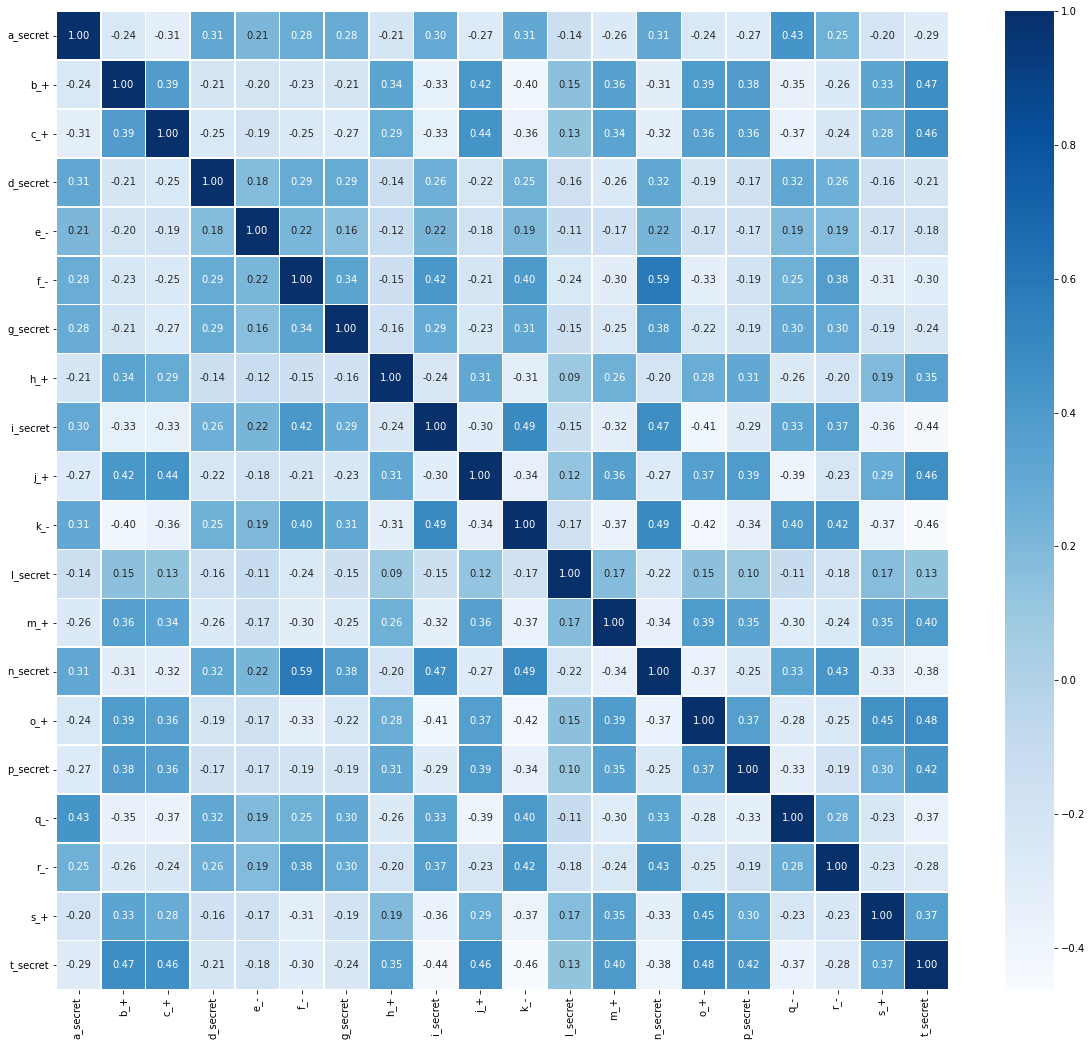

In [400]:
sns.heatmap(data=Machiavelli.corr(),annot=True,fmt='.2f', linewidths=.5,cmap='Blues')
fig=plt.gcf() # fig에 접근
fig.set_size_inches(20,18) # fig그림 크기 조절
plt.show()

#### 상관계수를 통하여 secret변수들의 성향을 알아보니 최종적으로 

#### - : a,d,e,f,g,i,k,n,q,r 

#### +: b,c,h,j,l,m,o,p,s,t


#### 의 형태가 된다

<AxesSubplot:xlabel='a_-', ylabel='count'>

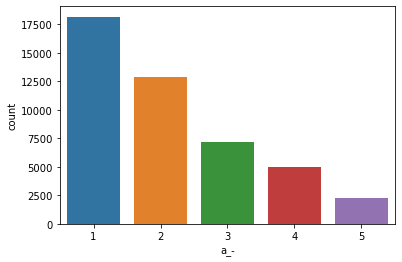

In [401]:
Machiavelli.columns=['a_-','b_+','c_+','d_-','e_-','f_-','g_-','h_+','i_-','j_+','k_-','l_+','m_+','n_-','o_+','p_+','q_-','r_-','s_+','t_+']
sns.countplot('a_-',data=Machiavelli)

#### Q_A변수들이 모두 긍정적 지표를 나타내는 점수가 될 수 있게 -를 나타내는 변수들은 뒤집어준다.

In [402]:
for i in ["QaA","QdA","QeA","QfA","QgA","QiA","QkA","QnA","QqA","QrA"]:
    data_tr[i]=6-data_tr[i]
    data_te[i]=6-data_te[i]

<AxesSubplot:xlabel='QaA', ylabel='count'>

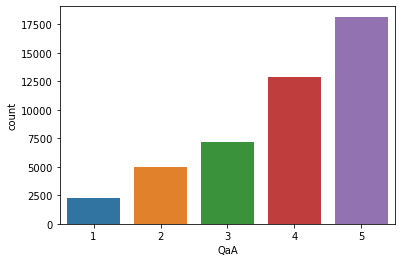

In [403]:
sns.countplot('QaA',data=data_tr)

#### 공식에 따른 Machiavelli변수 생성

In [404]:
data_tr['Machiavelli Score']=data_tr[['QaA','QbA','QcA','QdA','QeA','QfA','QgA','QhA','QiA','QjA','QkA','QlA','QmA','QnA','QoA','QpA','QqA','QrA','QsA','QtA']].sum(axis=1)
data_te['Machiavelli Score']=data_te[['QaA','QbA','QcA','QdA','QeA','QfA','QgA','QhA','QiA','QjA','QkA','QlA','QmA','QnA','QoA','QpA','QqA','QrA','QsA','QtA']].sum(axis=1)

### TIPI점수 추가
TIPI점수는 10개의 tp변수들을 2개씩 짝을 지어 각 성격의 측도를 나타내는 점수이다. 그 공식에 따라 변수를 한다.

In [405]:
data_tr['tp_Sincerity'] = ( data_tr['tp03'] + 8 - data_tr['tp08'] ) / 2
data_tr['tp_Affinity'] = ( data_tr['tp07'] + 8 - data_tr['tp02'] ) / 2
data_tr['tp_Emotional Stability'] = ( data_tr['tp09'] + 8 - data_tr['tp04'] ) / 2
data_tr['tp_Experience Openess'] = ( data_tr['tp05'] + 8 - data_tr['tp10'] ) / 2
data_tr['tp_Extrovertness'] = ( data_tr['tp01'] + 8 - data_tr['tp06'] ) / 2

data_te['tp_Sincerity'] = ( data_te['tp03'] + 8 - data_te['tp08'] ) / 2
data_te['tp_Affinity'] = ( data_te['tp07'] + 8 - data_te['tp02'] ) / 2
data_te['tp_Emotional Stability'] = ( data_te['tp09'] + 8 - data_te['tp04'] ) / 2
data_te['tp_Experience Openess'] = ( data_te['tp05'] + 8 - data_te['tp10'] ) / 2
data_te['tp_Extrovertness'] = ( data_te['tp01'] + 8 - data_te['tp06'] ) / 2

### Wf, Wr 변수추가
 Wf, Wr변수들은 단어에 대한 지식을 나타내는 변수이다. 각 변수들의 합을 수치화하는 것은 그 사람의 성향과 지식수준을 나타낼 수 있다고 판단하기에 Wf와 Wr변수들을 활용하여 새로운 변수를 만들어준다. 

In [406]:
data_tr['wf_sum'] = data_tr['wf_01'] + data_tr['wf_02'] + data_tr['wf_03']
data_tr['wr_sum'] = data_tr['wr_01'] + data_tr['wr_02'] + data_tr['wr_03'] + data_tr['wr_04'] + data_tr['wr_05'] + data_tr['wr_06'] + data_tr['wr_07'] + data_tr['wr_08'] + data_tr['wr_09'] + data_tr['wr_10'] + data_tr['wr_11'] + data_tr['wr_12'] + data_tr['wr_13']
data_tr['wfr_sum'] = data_tr['wf_sum'] + data_tr['wr_sum']
data_tr['wfr_minus']=data_tr['wf_sum']-data_tr['wr_sum']  #비율변수
data_tr['wfr_sum2'] = data_tr['wf_sum']/3 + data_tr['wr_sum']/13
data_tr['wfr_minus2']=data_tr['wf_sum']/3-data_tr['wr_sum']/13  #비율변수


data_te['wf_sum'] = data_te['wf_01'] + data_te['wf_02'] + data_te['wf_03']
data_te['wr_sum'] = data_te['wr_01'] + data_te['wr_02'] + data_te['wr_03'] + data_te['wr_04'] + data_te['wr_05'] + data_te['wr_06'] + data_te['wr_07'] + data_te['wr_08'] + data_te['wr_09'] + data_te['wr_10'] + data_te['wr_11'] + data_te['wr_12'] + data_te['wr_13']
data_te['wfr_sum'] = data_te['wf_sum'] + data_te['wr_sum']
data_te['wfr_minus']=data_te['wf_sum']-data_te['wr_sum']  #비율변수
data_te['wfr_sum2'] = data_te['wf_sum']/3 + data_te['wr_sum']/13
data_te['wfr_minus2']=data_te['wf_sum']/3-data_te['wr_sum']/13  #비율변수

### 의미가 있다고 생각되는 변수 추가
target과의 연관성 등을 고려하여 의미가 있다고 여겨지는 변수들을 추가한다.

#### 무작정변수를 늘리는 것은 좋은 방법이 아니므로 후에 feature importance와 backwardselection을 통해 변수를 제거한다

In [407]:
data_tr['religion_other'] = list(map(lambda x: 1 if str(x)== 'Other' else 0, train['religion']) )
data_te['religion_other'] = list(map(lambda x: 1 if str(x)== 'Other' else 0, test['religion']) )

data_tr['race_Asian'] = list(map(lambda x: 1 if str(x)== 'Asian' else 0, train['race']) )
data_te['race_Asian'] = list(map(lambda x: 1 if str(x)== 'Asian' else 0, test['race']) )

data_tr['married_currently married'] = list(map(lambda x: 1 if str(x)== '2' else 0, train['married']) )
data_te['married_currently married'] = list(map(lambda x: 1 if str(x)== '2' else 0, test['married']) )

data_tr['education_university degree'] = list(map(lambda x: 1 if str(x)== '3' else 0, train['education']) )
data_te['education_university degree'] = list(map(lambda x: 1 if str(x)== '3' else 0, test['education']) )

data_tr['gold'] = train['urban'] + train['education']
data_te['gold'] = test['urban'] + test['education']

data_tr['soil'] = 7 - data_tr['gold']
data_te['soil'] = 7 - data_te['gold']

In [408]:

data_tr['time_sum'] = train['QaE'] + train['QbE'] + train['QcE'] + train['QdE'] + train['QeE'] + train['QfE'] + train['QgE'] + train['QhE'] + train['QiE'] + train['QjE'] + train['QkE'] + train['QlE'] + train['QmE'] + train['QnE'] + train['QoE'] + train['QpE'] + train['QqE'] + train['QrE'] + train['QsE'] + train['QtE']
    
data_te['time_sum'] = test['QaE'] + test['QbE'] + test['QcE'] + test['QdE'] + test['QeE'] + test['QfE'] + test['QgE'] + test['QhE'] + test['QiE'] + test['QjE'] + test['QkE'] + test['QlE'] + test['QmE'] + test['QnE'] + test['QoE'] + test['QpE'] + test['QqE'] + test['QrE'] + test['QsE'] + test['QtE']

In [409]:
data_tr['race_Asian'] = list(map(lambda x: 1 if str(x)== 'Asian' else 0, train['race']) )
data_tr['race_Black'] = list(map(lambda x: 1 if str(x)== 'Black' else 0, train['race']) )
data_tr['race_Other'] = list(map(lambda x: 1 if str(x)== 'Other' else 0, train['race']) )

data_tr['Jewish'] = list(map(lambda x: 1 if str(x)== 'Jewish' else 0, train['religion']) )
data_tr['Christian_Catholic'] = list(map(lambda x: 1 if str(x)== 'Christian_Catholic' else 0, train['religion']) )
data_tr['Christian_Protestant'] = list(map(lambda x: 1 if str(x)== 'Christian_Protestant' else 0, train['religion']) )

data_tr['age_20s'] = list(map(lambda x: 1 if str(x)== '20s' else 0, train['age_group']) )
data_tr['age_30s'] = list(map(lambda x: 1 if str(x)== '30s' else 0, train['age_group']) )

data_te['race_Asian'] = list(map(lambda x: 1 if str(x)== 'Asian' else 0, test['race']) )
data_te['race_Black'] = list(map(lambda x: 1 if str(x)== 'Black' else 0, test['race']) )
data_te['race_Other'] = list(map(lambda x: 1 if str(x)== 'Other' else 0, test['race']) )

data_te['Jewish'] = list(map(lambda x: 1 if str(x)== 'Jewish' else 0, test['religion']) )
data_te['Christian_Catholic'] = list(map(lambda x: 1 if str(x)== 'Christian_Catholic' else 0, test['religion']) )
data_te['Christian_Protestant'] = list(map(lambda x: 1 if str(x)== 'Christian_Protestant' else 0, test['religion']) )

data_te['age_20s'] = list(map(lambda x: 1 if str(x)== '20s' else 0, test['age_group']) )
data_te['age_30s'] = list(map(lambda x: 1 if str(x)== '30s' else 0, test['age_group']) )

data_tr['solo'] = list(map(lambda x: 1 if  x == 1  else 0, train['familysize']) )
data_te['solo'] = list(map(lambda x: 1 if  x == 1  else 0, test['familysize']) )

## 4.예측모델링

#### 4-1. 모델링 & 평가(교차검증)
#### 4-2. 변수 제거 후 모델링 및 평가

#### 공모전이다 보니 점수에 초점을 맞추어 모델을 선정하였고, 그 모델에 알맞게 변수를 선정하였다. 모델은 lightGBM을 사용하였고, feature_importance와 Backward selection을 이용하여 변수를 선정하였다.

### 모델링& 평가

In [410]:
#데이터분리
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV, train_test_split
#모델
import lightgbm as lgbm
#성과 평가 지표
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix

#모델링& 교차검증
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
y = data_tr['voted']
X = data_tr.drop('voted',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

lgbm_wrapper_time=LGBMClassifier(learning_rate=0.01, max_depth=10, n_estimators=500, random_state=1)
#LGBMClassifier(learning_rate=0.01, max_depth=8, n_estimators=300, random_state=1)
evals=[(X_test,y_test)]
model1 = lgbm_wrapper_time.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="logloss",eval_set=evals,verbose=True)
lgbm_wrapper_time_preds=lgbm_wrapper_time.predict(X_test)
lgbm_time_roc_auc = roc_auc_score(lgbm_wrapper_time_preds,y_test )
print('LightGBM 최적 파라미터 roc_auc 예측 점수:',lgbm_time_roc_auc)

[1]	valid_0's binary_logloss: 0.686611
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.684495
[3]	valid_0's binary_logloss: 0.68242
[4]	valid_0's binary_logloss: 0.680368
[5]	valid_0's binary_logloss: 0.678352
[6]	valid_0's binary_logloss: 0.676391
[7]	valid_0's binary_logloss: 0.674449
[8]	valid_0's binary_logloss: 0.672564
[9]	valid_0's binary_logloss: 0.670699
[10]	valid_0's binary_logloss: 0.668883
[11]	valid_0's binary_logloss: 0.667082
[12]	valid_0's binary_logloss: 0.665335
[13]	valid_0's binary_logloss: 0.6636
[14]	valid_0's binary_logloss: 0.661927
[15]	valid_0's binary_logloss: 0.660283
[16]	valid_0's binary_logloss: 0.658667
[17]	valid_0's binary_logloss: 0.657052
[18]	valid_0's binary_logloss: 0.655504
[19]	valid_0's binary_logloss: 0.653959
[20]	valid_0's binary_logloss: 0.652453
[21]	valid_0's binary_logloss: 0.650952
[22]	valid_0's binary_logloss: 0.649525
[23]	valid_0's binary_logloss: 0.648074
[24]	valid_0's binary_logloss:

[204]	valid_0's binary_logloss: 0.564046
[205]	valid_0's binary_logloss: 0.563942
[206]	valid_0's binary_logloss: 0.563822
[207]	valid_0's binary_logloss: 0.563721
[208]	valid_0's binary_logloss: 0.563606
[209]	valid_0's binary_logloss: 0.563491
[210]	valid_0's binary_logloss: 0.563389
[211]	valid_0's binary_logloss: 0.563301
[212]	valid_0's binary_logloss: 0.563194
[213]	valid_0's binary_logloss: 0.5631
[214]	valid_0's binary_logloss: 0.563011
[215]	valid_0's binary_logloss: 0.562931
[216]	valid_0's binary_logloss: 0.562826
[217]	valid_0's binary_logloss: 0.562714
[218]	valid_0's binary_logloss: 0.562616
[219]	valid_0's binary_logloss: 0.56253
[220]	valid_0's binary_logloss: 0.562421
[221]	valid_0's binary_logloss: 0.562318
[222]	valid_0's binary_logloss: 0.562244
[223]	valid_0's binary_logloss: 0.56215
[224]	valid_0's binary_logloss: 0.562047
[225]	valid_0's binary_logloss: 0.561951
[226]	valid_0's binary_logloss: 0.561883
[227]	valid_0's binary_logloss: 0.56179
[228]	valid_0's binar

[406]	valid_0's binary_logloss: 0.556449
[407]	valid_0's binary_logloss: 0.556446
[408]	valid_0's binary_logloss: 0.556455
[409]	valid_0's binary_logloss: 0.556443
[410]	valid_0's binary_logloss: 0.556448
[411]	valid_0's binary_logloss: 0.556453
[412]	valid_0's binary_logloss: 0.556442
[413]	valid_0's binary_logloss: 0.556427
[414]	valid_0's binary_logloss: 0.556428
[415]	valid_0's binary_logloss: 0.556416
[416]	valid_0's binary_logloss: 0.556408
[417]	valid_0's binary_logloss: 0.556381
[418]	valid_0's binary_logloss: 0.556377
[419]	valid_0's binary_logloss: 0.556373
[420]	valid_0's binary_logloss: 0.556361
[421]	valid_0's binary_logloss: 0.556355
[422]	valid_0's binary_logloss: 0.556357
[423]	valid_0's binary_logloss: 0.556367
[424]	valid_0's binary_logloss: 0.556354
[425]	valid_0's binary_logloss: 0.556359
[426]	valid_0's binary_logloss: 0.556361
[427]	valid_0's binary_logloss: 0.556332
[428]	valid_0's binary_logloss: 0.556337
[429]	valid_0's binary_logloss: 0.556329
[430]	valid_0's 

### 변수제거
feature_importance와 Backwardselection을 통해 모델에 적절한 변수들을 선택한다.

#### feature_importance

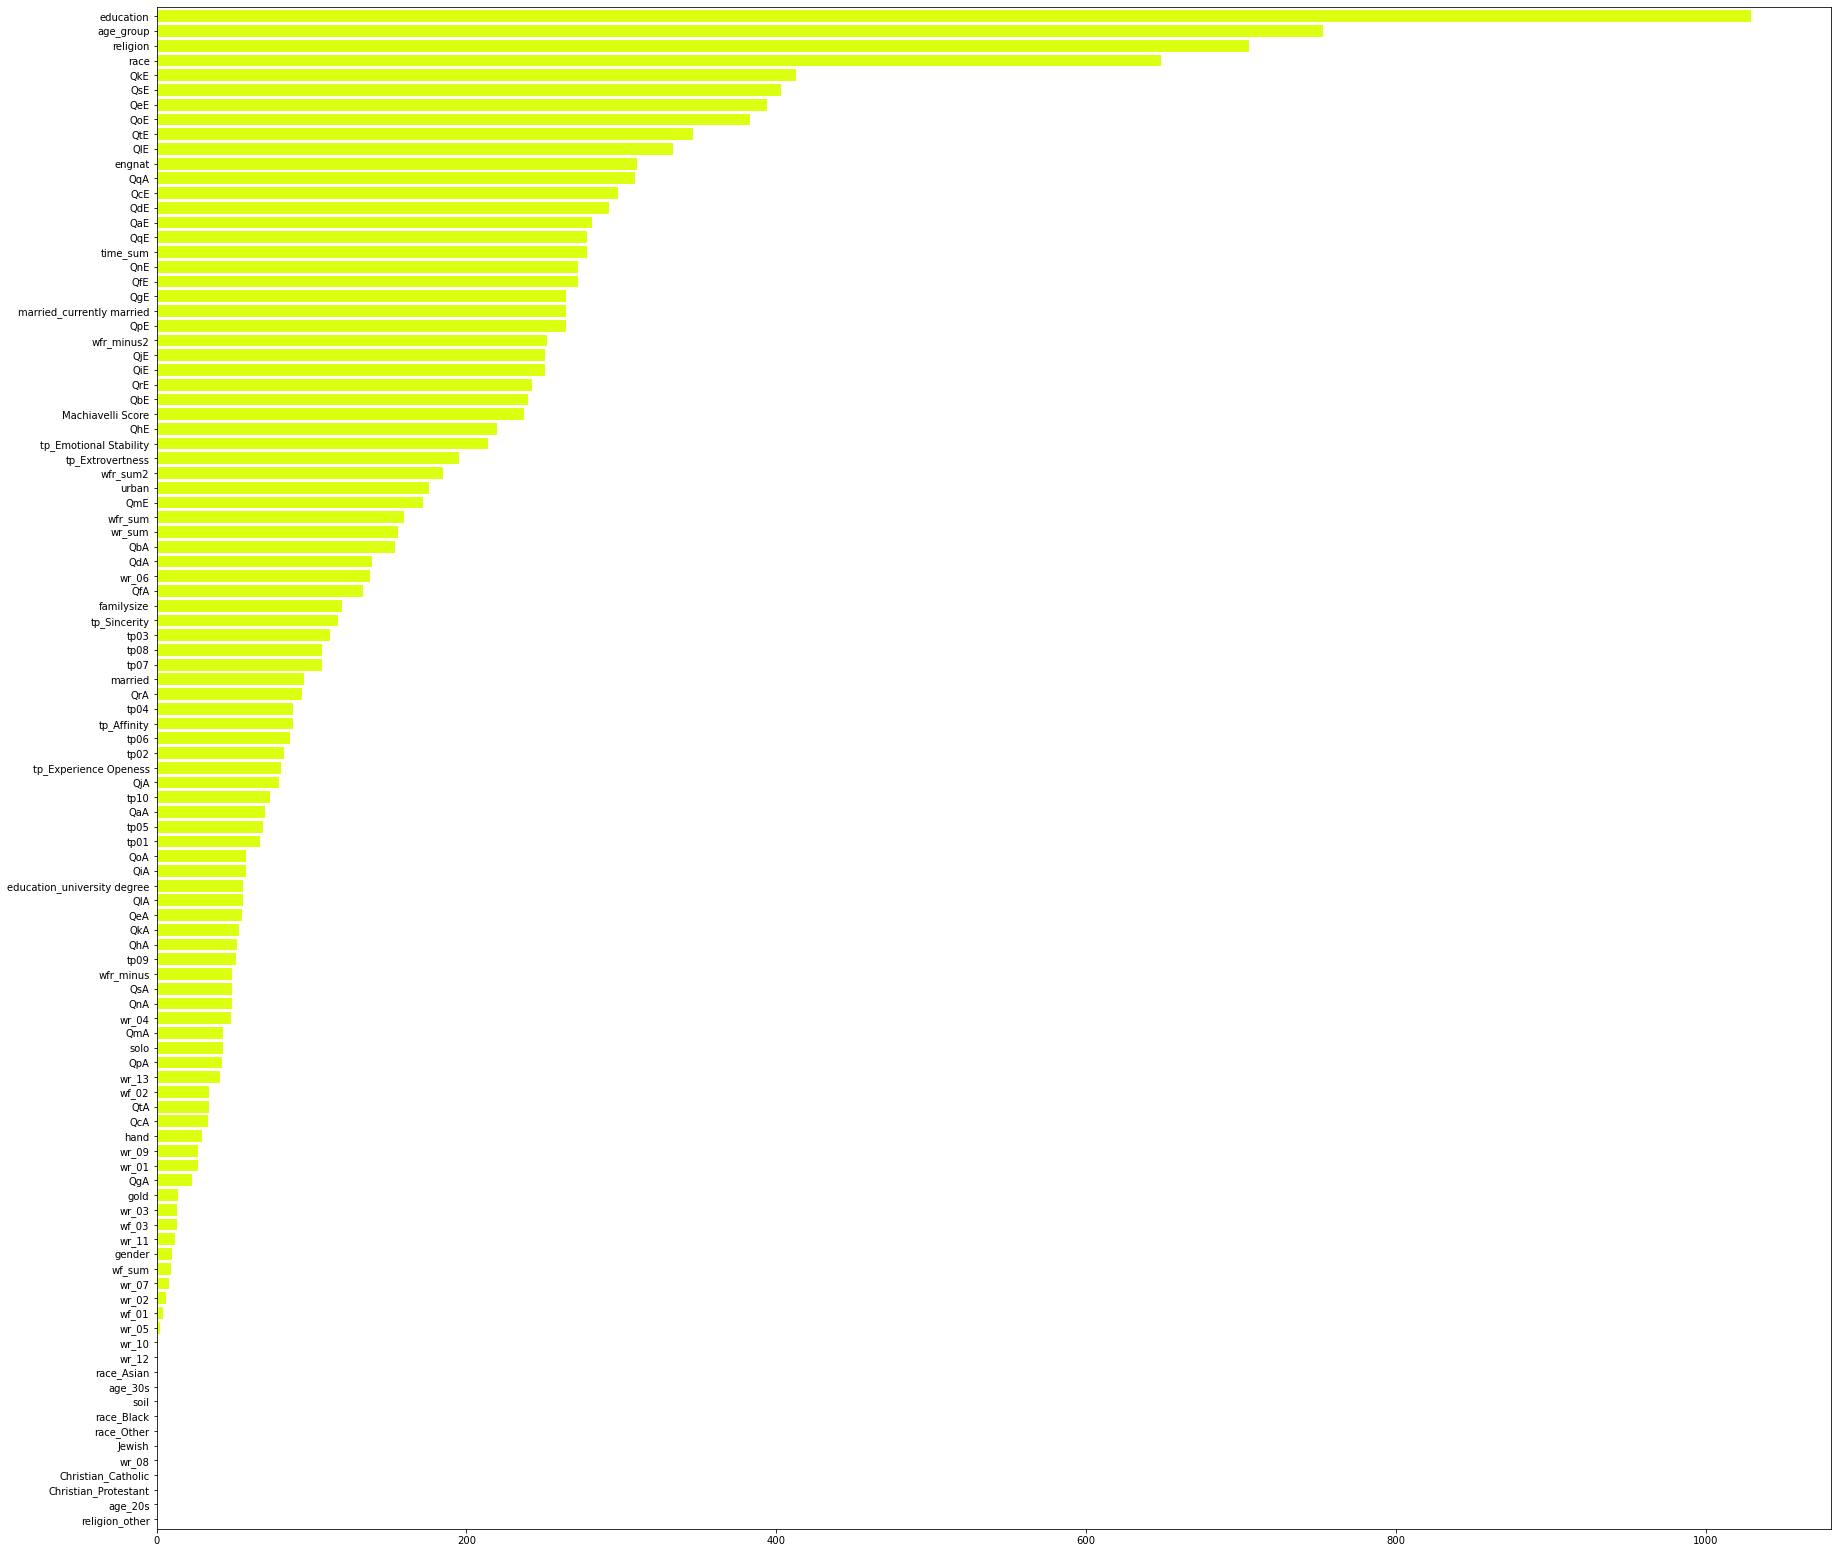

In [411]:
pd.Series(lgbm_wrapper_time.feature_importances_,X.columns).sort_values(ascending=True).plot.barh(width=0.8,color='#ddff11')
fig=plt.gcf() # fig에 접근
fig.set_size_inches(30,28) # fig그림 크기 조절
plt.show()

#### Backwardselection
시간관계상 과거의 수치들을 그대로 사용한다.

In [412]:
#from mlxtend.feature_selection import SequentialFeatureSelector as SFS 
#import time
#start = time.time()  # 시작 시간 저장
 
#lgbm_wrapper_time3=LGBMClassifier(learning_rate=0.01,n_estimators=500,random_state=1, n_jobs=-1) 
#sfs3 = SFS(lgbm_wrapper_time3, 
#           k_features=50, 
#           forward=False, 
#           floating=True, 
#           verbose=2, 
#           scoring='roc_auc', 
#           cv=5,
#           n_jobs=-1) 

#sfs3 = sfs3.fit(X, y) 
#print("time :", time.time() - start)

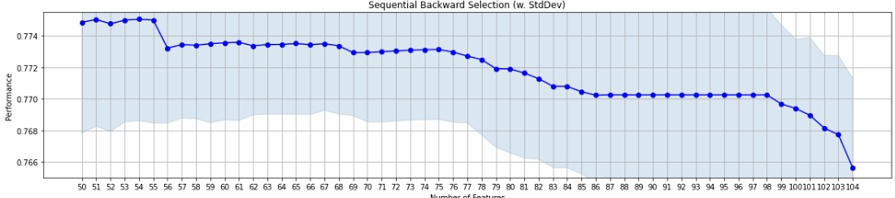

### 선택된 변수들을 가지고 다시 모델링을 하고 예측을 실행

In [413]:
X_train = data_tr[['QaA','QbA','QcA','QdA','QdE','QeE','QfA','QfE','QgA','QgE','QhA','QiA','QiE','QjA','QjE','QkA','QkE','QlA','QlE','QmA','QmE','QnA','QnE','QoA','QoE','QpA','QpE','QqA','QqE','QrA','QrE','QsA','QsE','age_group','education','engnat','familysize','gender','married','race','religion','tp01','tp02','tp03','tp06','tp07','tp09','urban','wf_02','wf_03','wr_01','wr_03','wr_04','wr_06','wr_07','wr_11','wr_12','wr_13','Machiavelli Score','wf_sum','wr_sum','wfr_sum','wfr_minus','tp_Sincerity','tp_Affinity','tp_Emotional Stability','tp_Experience Openess','tp_Extrovertness','married_currently married','education_university degree','time_sum','soil','wfr_sum2','wfr_minus2','solo']]
X_test = data_te[['QaA','QbA','QcA','QdA','QdE','QeE','QfA','QfE','QgA','QgE','QhA','QiA','QiE','QjA','QjE','QkA','QkE','QlA','QlE','QmA','QmE','QnA','QnE','QoA','QoE','QpA','QpE','QqA','QqE','QrA','QrE','QsA','QsE','age_group','education','engnat','familysize','gender','married','race','religion','tp01','tp02','tp03','tp06','tp07','tp09','urban','wf_02','wf_03','wr_01','wr_03','wr_04','wr_06','wr_07','wr_11','wr_12','wr_13','Machiavelli Score','wf_sum','wr_sum','wfr_sum','wfr_minus','tp_Sincerity','tp_Affinity','tp_Emotional Stability','tp_Experience Openess','tp_Extrovertness','married_currently married','education_university degree','time_sum','soil','wfr_sum2','wfr_minus2','solo']]
y = data_tr['voted']

In [414]:
lgbm_wrapper=LGBMClassifier(learning_rate=0.01, n_estimators=500,random_state=1)
lgbm_wrapper.fit(X_train, y)
LGBM2=pd.DataFrame(lgbm_wrapper.predict_proba(X_test))
LGBM2['Probability']=LGBM2[1]

In [415]:
LGBM2

,0,1,Probability
0,0.327160,0.672840,0.672840
1,0.149348,0.850652,0.850652
2,0.508937,0.491063,0.491063
3,0.568819,0.431181,0.431181
4,0.292175,0.707825,0.707825
...,...,...,...
11378,0.556158,0.443842,0.443842
11379,0.121030,0.878970,0.878970
11380,0.519008,0.480992,0.480992
11381,0.448886,0.551114,0.551114


## 5. 아쉬운 점 & 배울 점

### 5-1. 아쉬운 점

1. y값(target)을 다른 변수와 비교하는 등 EDA를 했어야했다.
2. 가장 중요한 함수인 Machiavelli score와 tipi 변수 변환에서 실수를 했다.


### 5-2. 배울 점
#### 1.변수가 너무 많았다.

예를들어 마키아벨리 점수, 시간변수, tipi점수(대부분 팀에서는 제거함)

#### 2.앙상블
생각보다 단순한 형식으로 앙상블이 가능하다.
앙상블은 꼭 모델을 다 다르게 안하더라도 변수에 따라서도 나눌 수 있다.